In [2]:
# import all relevant libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib

import wfdb

# assign the correct path to downloaded data and filenames
# realpath is this script path, while data is subfolder in the same dir
# parent_dir =  os.path.dirname(os.path.realpath(__file__))

parent_dir = pathlib.Path(os.path.abspath('')).parents[0]
data_dir =  os.path.join(parent_dir,'data\\')
processed_dir =  os.path.join(parent_dir,'data\\processed\\')


filenames = []

for i in range(10):
    filenames.append('infant'+str(i+1))

# print and list all relevant filenames, as a quick check
print(parent_dir)
print(data_dir)
print(processed_dir)
print(filenames)

def describe_df(df):
    desc = df.describe()
    desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
    desc.loc['nunique'] = df.nunique()
    desc.loc['count_na'] = df.isna().sum()
    desc.iloc[1:] = desc.iloc[1:].applymap('{:.6f}'.format)
    print(desc)

f:\Education\ecg_resp
f:\Education\ecg_resp\data\
f:\Education\ecg_resp\data\processed\
['infant1', 'infant2', 'infant3', 'infant4', 'infant5', 'infant6', 'infant7', 'infant8', 'infant9', 'infant10']


In [3]:
df_csv = pd.DataFrame()

# if windows
if os.name == 'nt':
    df_csv = pd.read_csv(data_dir+'processed_old\subsampled{postfix}.csv'.format(postfix='_'+filenames[3]))
else:
    df_csv = pd.read_csv(data_dir+'processed_old/subsampled{postfix}.csv'.format(postfix='_'+filenames[3]))

# filter data both rows & columns
df = df_csv[20000:1000000].copy()
df = df[['hrs', 'resp', 'sig']]

# add time from index
df['time'] = df.index

# remove outliers
min_hrs = df['hrs'].mean()-3*df['hrs'].std()
max_hrs = df['hrs'].mean()+3*df['hrs'].std()

df = df[(df['hrs']>min_hrs)&(df['hrs']<max_hrs)]

# add unique id everytime hrs change
df['id'] = (df[['hrs']].diff() != 0).cumsum()

# print descriptions of the df
describe_df(df)

# group data into unique continuous hrs, i.e. the generated id
dfg = df.groupby('id')['resp'].apply(list).reset_index(name='resp')

# add back corresponding hrs to each id
dfg = pd.merge(dfg, df[['id', 'hrs']], on='id', how='left')

dfg['len'] = dfg['resp'].apply(lambda x: len(x))



FileNotFoundError: [Errno 2] No such file or directory: 'f:\\Education\\ecg_resp\\data\\processed_old\\subsampled_infant4.csv'

In [ ]:
dfg['len'].describe()

<AxesSubplot: ylabel='resp'>

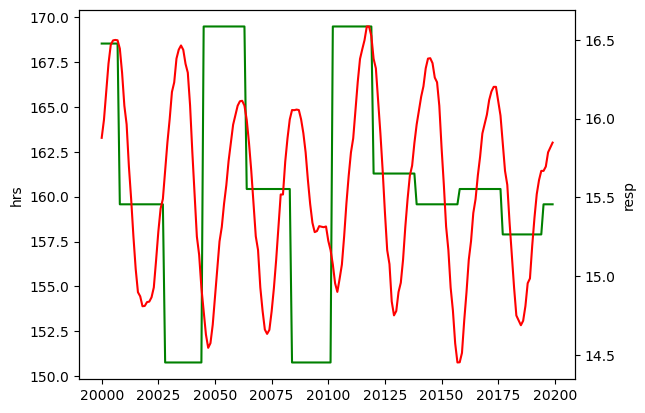

In [ ]:
# plot 

dfc = df[:200]

sns.lineplot(data=dfc['hrs'], color="g")
# sns.lineplot(data=df['resp'], color="r")
ax2 = plt.twinx()
# sns.lineplot(data=df['sig'], color="b", ax=ax2)
sns.lineplot(data=dfc['resp'], color="r", ax=ax2)

[  6  35  62  86 117 145 173]
7


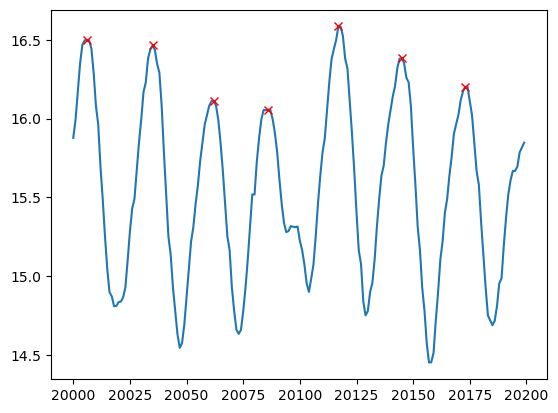

In [ ]:
from scipy.signal import find_peaks

dfc = df[:200]


indexes, _ = find_peaks(dfc['resp'], prominence=0.2)
print(indexes)
print(len(indexes))

x = indexes + 20000
y = dfc['resp'].loc[dfc.index.intersection(x)]


d = pd.DataFrame({"x": indexes + 20000, 'y': y })

plt.plot(dfc['time'], dfc['resp'])
plt.plot(x, y, 'xr')

plt.show()


In [ ]:
# dfc['resp_idx'] = np.arange(dfc.shape[0])
# dfc.loc[[20001],'resp_idx'] = 1
# dfc
dfc.describe()

hrs        resp         sig          time          id  resp_idx
count  200.000000  200.000000  200.000000    200.000000  200.000000       1.0
mean   160.402327   15.557727   -0.047153  20099.500000    6.400000       1.0
std      5.932218    0.571455    0.413113     57.879185    3.119077       NaN
min    150.753770   14.451683   -2.415188  20000.000000    1.000000       1.0
25%    157.894730   15.075731   -0.071017  20049.750000    4.000000       1.0
50%    160.427810   15.579201   -0.029965  20099.500000    6.000000       1.0
75%    161.290330   16.051891    0.014683  20149.250000    9.000000       1.0
max    169.491530   16.584870    1.887802  20199.000000   12.000000       1.0

In [ ]:
dfc = dfg[:1000]

df2Xy(df[:1000], feat_col='hrs', )
# X, y = dfc['resp'].values, dfc['hrs'].values 

# X.shape, y.shape, y[:10]


In [ ]:
from tsai.all import *

splits = RandomSplitter(valid_pct=0.2, seed=None)


tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X, y, tfms=tfms, batch_tfms=batch_tfms, bs=128, splits=splits)
dls.one_batch()


In [5]:
data_list = []
df_stat = pd.read_csv(processed_dir+'stat.csv')

# for i in range(len(filenames)):
for i in range(1):
    # set amount of row for each batch
    multiplier = 500000

    # find the maximum range for each
    n_batch = int(min(df_stat['sig_len_ecg'][i], df_stat['sig_len_resp'][i])/multiplier)
    for j in range(n_batch):

        fullfilename = 'dfg_'+filenames[i]+'_'+str(j)+'.csv'
        data = pd.read_csv(processed_dir+fullfilename)
        data_list.append(data)

data = pd.concat(data_list)
data

Unnamed: 0     id                                               resp  \
0             0   18.0  24.150288286886383,24.128654928008284,24.17565...   
1             1   19.0  23.55574390668473,23.516207078390263,23.458766...   
2             2   20.0  24.694106170408357,24.50686571942891,24.364383...   
3             3   21.0  23.792964876451517,23.7974407438056,23.7959487...   
4             4   22.0  22.52107256999753,22.57254504456957,22.4770598...   
..          ...    ...                                                ...   
940         957  959.0  24.17415957944153,24.225632054013573,24.219664...   
941         958  960.0  24.17117566787214,24.17415957944153,24.2256320...   
942         959  961.0  26.777622423737373,26.820889141493577,26.90891...   
943         960  962.0  24.458377156426263,24.41585641656241,24.462853...   
944         961  963.0  24.98205363685483,24.932073118067485,24.935057...   

             hr  
0    164.233577  
1    163.179916  
2    165.605096  
3    162.162162  
4    149.068323  
..          ...  
940  148.453608  
941  142.857143  
942  160.493827  
943  156.576200  
944  149.068323  

[15121 rows x 4 columns]

In [6]:
data.shape

(15121, 4)

In [7]:
from fastai.tabular.all import *
#  import FillMissing, Categorify, Normalize, TabularList


col = data.columns.to_list()[:-1]

 
path = ''
splits = RandomSplitter(valid_pct=0.2)(range_of(data))

to = TabularPandas(data, 
                procs=[ Categorify, FillMissing, Normalize ],
                # cat_names = [],
                cont_names = col,
                y_names='hr',
                splits=splits)

dls = to.dataloaders(bs=64)
dls.show_batch()



c:\Users\test\miniconda3\envs\boost\lib\site-packages\fastai\tabular\core.py:273: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  store_attr(but='to', means=dict(getattr(to, 'train', to).conts.mean()),
c:\Users\test\miniconda3\envs\boost\lib\site-packages\fastai\tabular\core.py:274: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stds=dict(getattr(to, 'train', to).conts.std(ddof=0)+1e-7))


ValueError: Unable to coerce to Series, length must be 3: given 2

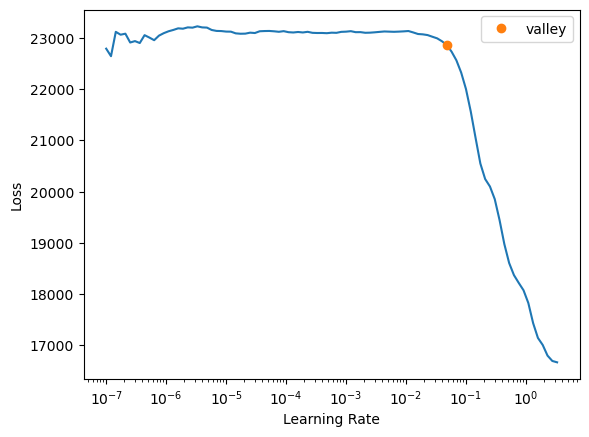

In [16]:
learn = tabular_learner(dls, metrics=[R2Score(), mse, mae])
learning_rate = learn.lr_find()

learn.fit_one_cycle(10, learning_rate)
learn.show_results()


In [20]:
learn.fit_one_cycle(1, learning_rate)
learn.show_results()


In [ ]:
dl = learn.dls.test_dl(data)

tr = learn.validate(dl=dl)
# va = learn.validate(learn.data.valid_dl)
print("The Metrics used In Evaluating The Network:", str(learn.metrics))

print("\nThe calculated RMSE & R-Squared For The Training Set :", tr[1:])
# print("\nThe calculated RMSE & R-Squared For The Validation Set :", va[1:])


The Metrics used In Evaluating The Network: [<fastai.metrics.AccumMetric object at 0x0000025189B40A30>, <fastai.learner.AvgMetric object at 0x0000025189C73010>, <fastai.learner.AvgMetric object at 0x0000025189C72860>]

The calculated RMSE & R-Squared For The Training Set : [0.43259927139108123, 82.62745666503906, 5.739339828491211]


RMSE :  9.089964
R2 :  0.432599


<AxesSubplot: xlabel='y_actual', ylabel='y_pred'>

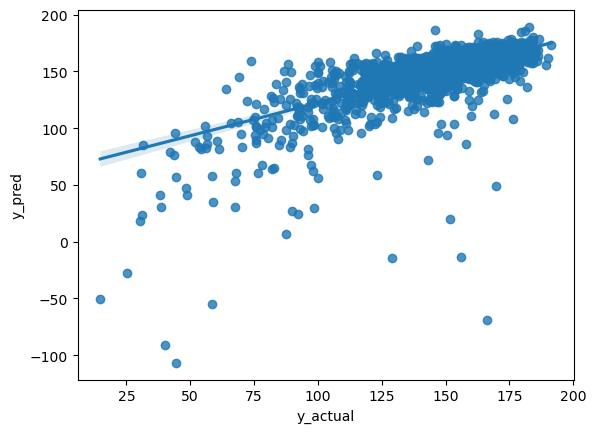

In [19]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score


# data = pd.read_csv(processed_dir+'ts1.csv')
dl = learn.dls.test_dl(data)

pred, test_y = learn.get_preds(dl=dl)

# RMSE Computation
r_mse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(r_mse))

# r2square compution
r2 = r2_score(test_y, pred)
print("R2 : % f" %(r2))


y_actual = test_y.numpy().flatten()
y_pred = pred.numpy().flatten()

dft = pd.DataFrame({'y_actual':y_actual, 'y_pred': y_pred})

# dft = dft[dft['y_pred'] > 0]

sns.regplot(data=dft, x='y_actual', y='y_pred')